In [1]:
import torch
import ChemSurrogate.data_processing as dp
from ChemSurrogate.configs import (
    DatasetConfig,
    AEConfig,
    EMConfig,
)
import ChemSurrogate.analysis as analysis
from ChemSurrogate.trainer import (
    load_autoencoder_objects,
    load_emulator_objects,
    load_skipcon_emulator_objects,
)
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
import pandas as pd
import os
import gc
import random

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# species_of_interest = ["H", "H2", "O", "C", "N", "SPlus", "MG", "SIPlus", "CL", "CPlus", "BULK_CO", "BULK_H", "E_minus", "CO", "BULK_CO"]
species_of_interest = ["C"]

In [2]:
# Load the models.
emulator, autoencoder, _, _ = load_skipcon_emulator_objects(is_inference=True)

# Load the datasets
training_t, training_indices = dp.load_tensors_from_hdf5(category="training")
validation_t, validation_indices = dp.load_tensors_from_hdf5(category="validation")

Loading Pretrained Model
Inference Mode Activated (parameters frozen)
Total Parameters: 280088


### This section is for obtaining the error plots across species and timesteps.

In [8]:
def plot_error_vs_time(
    errors: torch.Tensor,
    label: str = "Mean MRE across species",
    save_path: str = "plots/errors/unnamed.png",
):
    """
    Helper function for plotting errors across time.
    """
    save_path = os.path.join(DatasetConfig.working_path, save_path)

    errors = errors.cpu().numpy()
    timesteps = np.arange(DatasetConfig.num_timesteps_per_model)

    plt.figure(figsize=(5, 4))
    plt.scatter(
        timesteps + 1,
        errors,
        label=f"{label}\nMin: {errors.min():.1f}%\nMax: {errors.max():.1f}%\nMean: {errors.mean():.1f}%",
        color="b",
        zorder=2,
    )
    plt.plot(timesteps + 1, errors, color="b", linewidth=1, alpha=0.7, zorder=1)

    plt.xlabel("Timestep Δt (x1kyr)")
    plt.ylabel(f"{label}")
    plt.title(f"{label} vs. Timestep")
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.savefig(save_path, dpi=200, bbox_inches="tight")
    plt.show()

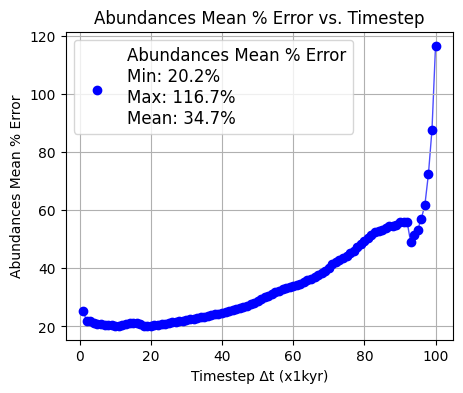

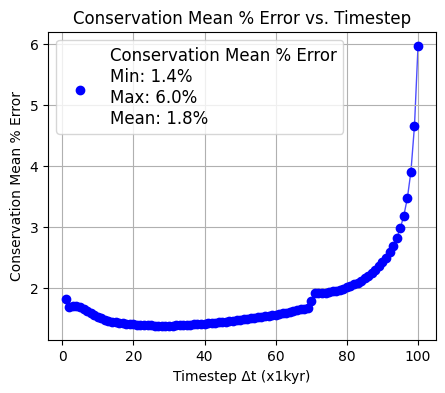

In [9]:
plot_error_vs_time(
    mean_rel_error_across_species * 100,
    label="Abundances Mean % Error",
    save_path="plots/errors/mean_relative_errors.png",
)
# analysis.plot_error_vs_time(
#     std_rel_error_timestep,
#     label = "STD of Mean Relative Error Across Species",
#     save_path = "plots/errors/std_relative_errors.png"
#     )
plot_error_vs_time(
    mean_conservation_error_timestep * 100,
    label="Conservation Mean % Error",
    save_path="plots/errors/conservation_errors.png",
)

In [7]:
timestep = 90
num_samples = 100000

filtered_t = training_t[training_t[:, 2] == timestep * 1000][
    :, DatasetConfig.num_metadata : -AEConfig.latent_dim
].numpy()
dp.inverse_physical_parameter_scaling(
    filtered_t[:, : DatasetConfig.num_physical_parameters]
)
dp.inverse_abundances_scaling_np(filtered_t[:, DatasetConfig.num_physical_parameters :])
training_df = pd.DataFrame(
    filtered_t, columns=DatasetConfig.physical_parameters + DatasetConfig.species
)

initial_conditions = analysis.sample_initial_conditions(num_samples)
initial_conditions_with_time = analysis.add_timesteps_to_conditions(
    initial_conditions, timestep
)


with torch.no_grad():
    inputs = torch.from_numpy(initial_conditions_with_time).float()
    latent_components = dp.encoder_inferencing(
        autoencoder, inputs[:, -DatasetConfig.num_species :]
    )
    encoded_features = torch.cat(
        (
            inputs[:, : 1 + DatasetConfig.num_physical_parameters],
            latent_components.cpu(),
        ),
        dim=1,
    )
    encoded_features = dp.emulator_inferencing(emulator, encoded_features)
    decoded_features = (
        dp.decoder_inferencing(autoencoder, encoded_features).cpu().numpy()
    )

inference_df = analysis.reconstruct_results(
    initial_conditions_with_time, decoded_features
)

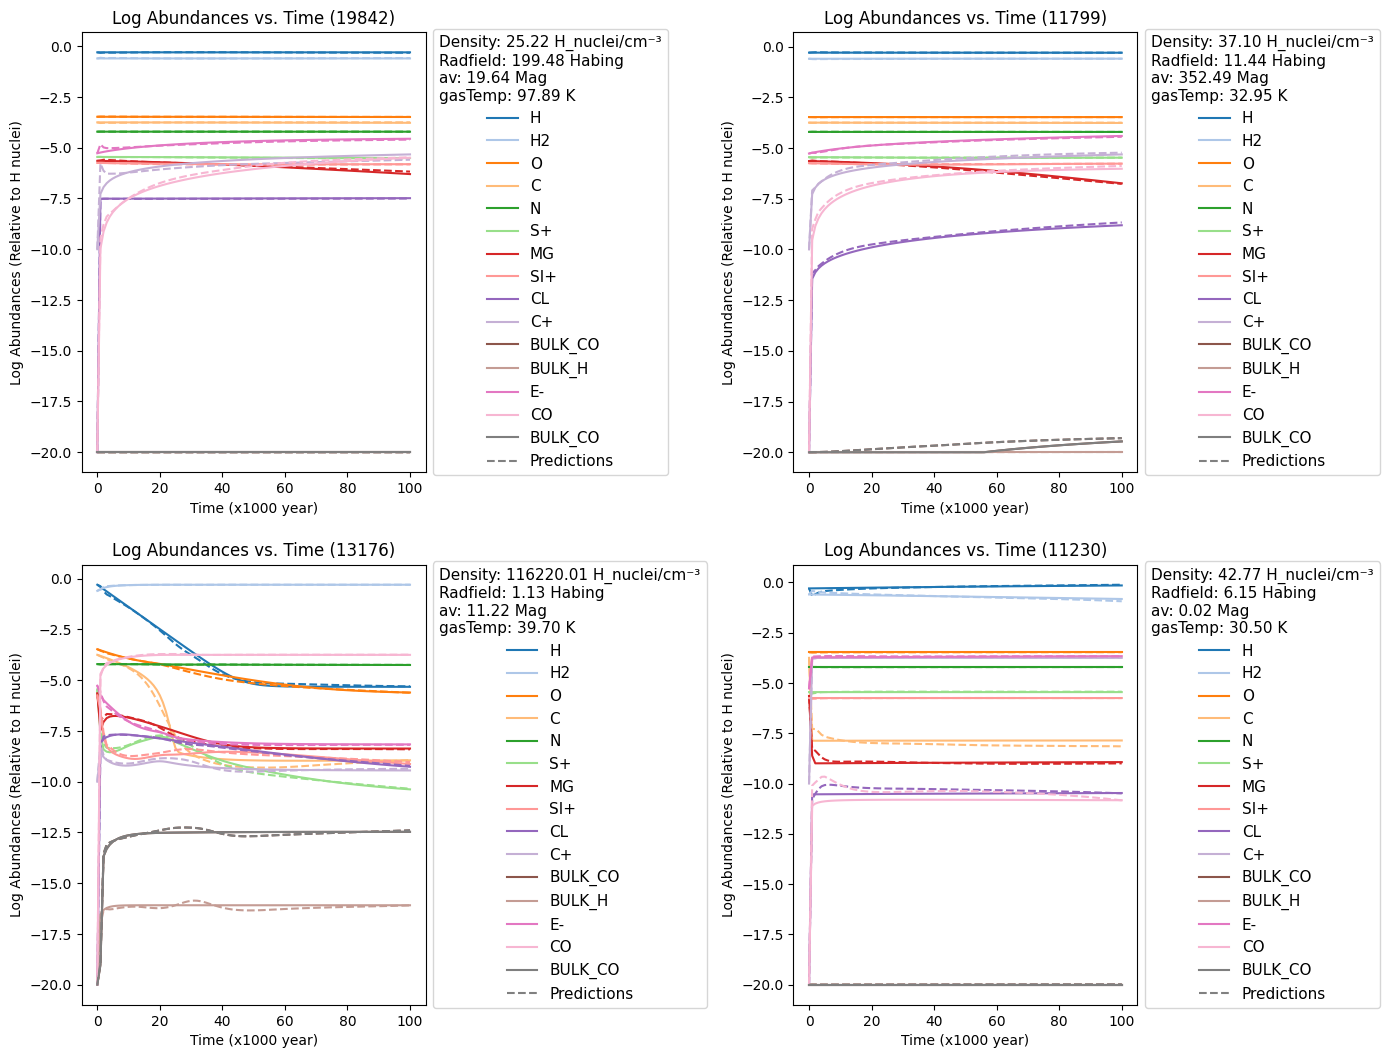

In [ ]:
def clean_label(label):
    return label.replace("Plus", "+").replace("_minus", "-")


num_plots = 2 * 2
sampled_model_indices = random.sample(range(20000), num_plots)

fig, axes = plt.subplots(int(num_plots // 2), 2, figsize=(14, num_plots * 2.7))
axes = axes.flatten()

for i, model_idx_num in enumerate(sampled_model_indices):
    model_idx = validation_t[:, 1].unique()[model_idx_num]
    model_t = validation_t[validation_t[:, 1] == model_idx][:, 2 : -AEConfig.latent_dim]
    model_np = np.array(model_t)

    dp.inverse_abundances_scaling_np(
        model_np[:, 1 + DatasetConfig.num_physical_parameters :]
    )

    initial_conditions = model_t[0, 1:].unsqueeze(0)
    initial_conditions_with_time = analysis.add_multiple_timesteps_to_conditions(
        initial_conditions, num_timesteps=model_t.shape[0] - 1
    ).float()

    with torch.no_grad():
        encoded_features = dp.encoder_inferencing(
            autoencoder,
            initial_conditions_with_time[
                :, 1 + DatasetConfig.num_physical_parameters :
            ],
        )
        encoded_features = torch.cat(
            (
                initial_conditions_with_time[
                    :, : 1 + DatasetConfig.num_physical_parameters
                ],
                encoded_features.cpu(),
            ),
            dim=1,
        )
        encoded_features = dp.emulator_inferencing(emulator, encoded_features)
        decoded_features = (
            dp.decoder_inferencing(autoencoder, encoded_features).cpu().numpy()
        )

    initial_abundances = model_np[0, 1 + DatasetConfig.num_physical_parameters :][
        np.newaxis, :
    ]
    decoded_features = np.vstack([initial_abundances, decoded_features])

    columns = DatasetConfig.physical_parameters + DatasetConfig.species
    actual_df = pd.DataFrame(model_np[:, 1:], columns=columns)
    results_df = analysis.reconstruct_results(model_np, decoded_features)

    # Rename columns just for display purposes
    display_column_map = {col: clean_label(col) for col in actual_df.columns}
    actual_df.rename(columns=display_column_map, inplace=True)
    results_df.rename(columns=display_column_map, inplace=True)

    plt.sca(axes[i])

    physical_parameters = actual_df.loc[
        :, [clean_label(p) for p in DatasetConfig.physical_parameters]
    ]
    phys_params = physical_parameters.iloc[0]
    params_text = "\n".join(
        [f"{param}: {phys_params[param]:.2f}" for param in physical_parameters.columns]
    )

    timesteps = np.arange(0, min(len(actual_df), len(results_df)))
    colors = plt.colormaps.get_cmap("tab20")

    for idx, species in enumerate(species_of_interest):
        species_display = clean_label(species)
        plt.plot(
            timesteps,
            np.log10(actual_df[species_display])[: len(timesteps)],
            label=species_display,
            color=colors(idx),
            linestyle="-",
        )
        plt.plot(
            timesteps,
            np.log10(results_df[species_display])[: len(timesteps)],
            color=colors(idx),
            linestyle="--",
        )

    plt.plot([], [], linestyle="--", color="gray", label="Predictions")

    plt.xlabel("Time (x1000 year)")
    plt.ylabel("Log Abundances (Relative to H nuclei)")
    plt.title(f"Log Abundances vs. Time ({int(model_idx)})")
    plt.legend(
        loc="center left",
        bbox_to_anchor=(1, 0.5),
        title=params_text,
        fontsize=11,
        title_fontsize=11,
    )

    output_path = f"plots/abundances_vs_time/model_{int(model_idx)}.png"

    # Single figure output
    single_fig = plt.figure(figsize=(7, 6))
    for idx, species in enumerate(species_of_interest):
        species_display = clean_label(species)
        plt.plot(
            timesteps,
            np.log10(actual_df[species_display])[: len(timesteps)],
            label=species_display,
            color=colors(idx),
            linestyle="-",
        )
        plt.plot(
            timesteps,
            np.log10(results_df[species_display])[: len(timesteps)],
            color=colors(idx),
            linestyle="--",
        )

    plt.plot([], [], linestyle="--", color="gray", label="Predictions")

    plt.xlabel("Time (x1000 year)")
    plt.ylabel("Log Abundances (Relative to H nuclei)")
    plt.title(f"Log Abundances vs. Time")
    plt.legend(
        loc="center left",
        bbox_to_anchor=(1, 0.5),
        title=params_text,
        fontsize=11,
        title_fontsize=11,
    )
    plt.tight_layout()

    output_path = os.path.join(DatasetConfig.working_path, output_path)
    plt.savefig(output_path, dpi=200, bbox_inches="tight")
    plt.close(single_fig)

plt.tight_layout()
plt.show()
plt.close(fig)

In [ ]:
num_plots = 10 * 2
sampled_model_indices = random.sample(range(20000), num_plots)

fig, axes = plt.subplots(int(num_plots // 2), 2, figsize=(15, num_plots * 2))
axes = axes.flatten()

for plot_idx, model_idx_num in enumerate(sampled_model_indices):
    model_idx = validation_t[:, 1].unique()[model_idx_num]

    model_np = validation_t[validation_t[:, 1] == model_idx][
        :, 2 : -AEConfig.latent_dim
    ].numpy()

    abundances = model_np[:, 5:]
    abundances_t = torch.from_numpy(abundances)

    with torch.no_grad():
        encoded_features = dp.encoder_inferencing(autoencoder, abundances_t)

    time_indices = model_np[:, 0] / 1000
    encoded_features_np = encoded_features.cpu().numpy()

    for i in range(encoded_features_np.shape[1]):
        axes[plot_idx].plot(
            time_indices, encoded_features_np[:, i], label=f"Feature {i + 1}"
        )

    axes[plot_idx].set_xlabel("Time Index")
    axes[plot_idx].set_ylabel("Encoded Feature Value")
    axes[plot_idx].set_title(f"Model {model_idx_num}")
    axes[plot_idx].grid(True)

    if plot_idx == 0:
        axes[plot_idx].legend(loc="lower right")
    else:
        axes[plot_idx].legend(loc="lower right", fontsize="small")

plt.tight_layout()
plt.show()